In [1]:
from collections import  defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal
from pyro.optim import Adam

In [2]:
X = np.array([[1.], [2.], [3.]])
y = np.array([2., 4., 6.])
dataset = (X, y)

In [3]:
def model(X, y):
    coef = pyro.sample('coef', dist.Normal(0., 2.))

    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Normal(coef * X[:, 0], 0.1), obs=y)

In [4]:
def init_loc_fn(site):
    if site["name"] == "coef":
        return 0
    raise ValueError(site["name"])

def initialize(X, y, seed, optim, elbo):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
#     global_guide = AutoDelta(poutine.block(model, expose=['coef']),
#                              init_loc_fn=init_loc_fn)
    global_guide = AutoDiagonalNormal(model)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, X, y)

In [5]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO()

# Choose the best among 100 random initializations.
X = torch.tensor(X)
y = torch.tensor(y)
loss, seed = min((initialize(X, y, seed, optim, elbo), seed) for seed in range(100))
initialize(X, y, seed, optim, elbo)
print('seed = {}, initial_loss = {}'.format(seed, loss))

/opt/conda/lib/python3.9/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


seed = 60, initial_loss = 85.60121191507092


In [6]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [7]:
losses = []
for i in range(200):
    loss = svi.step(X, y)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

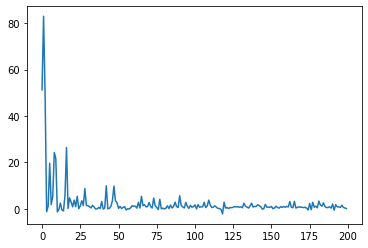

In [8]:
plt.plot(losses)

In [9]:
global_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([2.0395])
AutoDiagonalNormal.scale tensor([0.0276])
